In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
Europe = nx.Graph()
countries = pd.read_csv('countries.csv')
Europe.add_nodes_from(countries['country'])

land_borders_countries = pd.read_csv('land_borders_countries.csv')

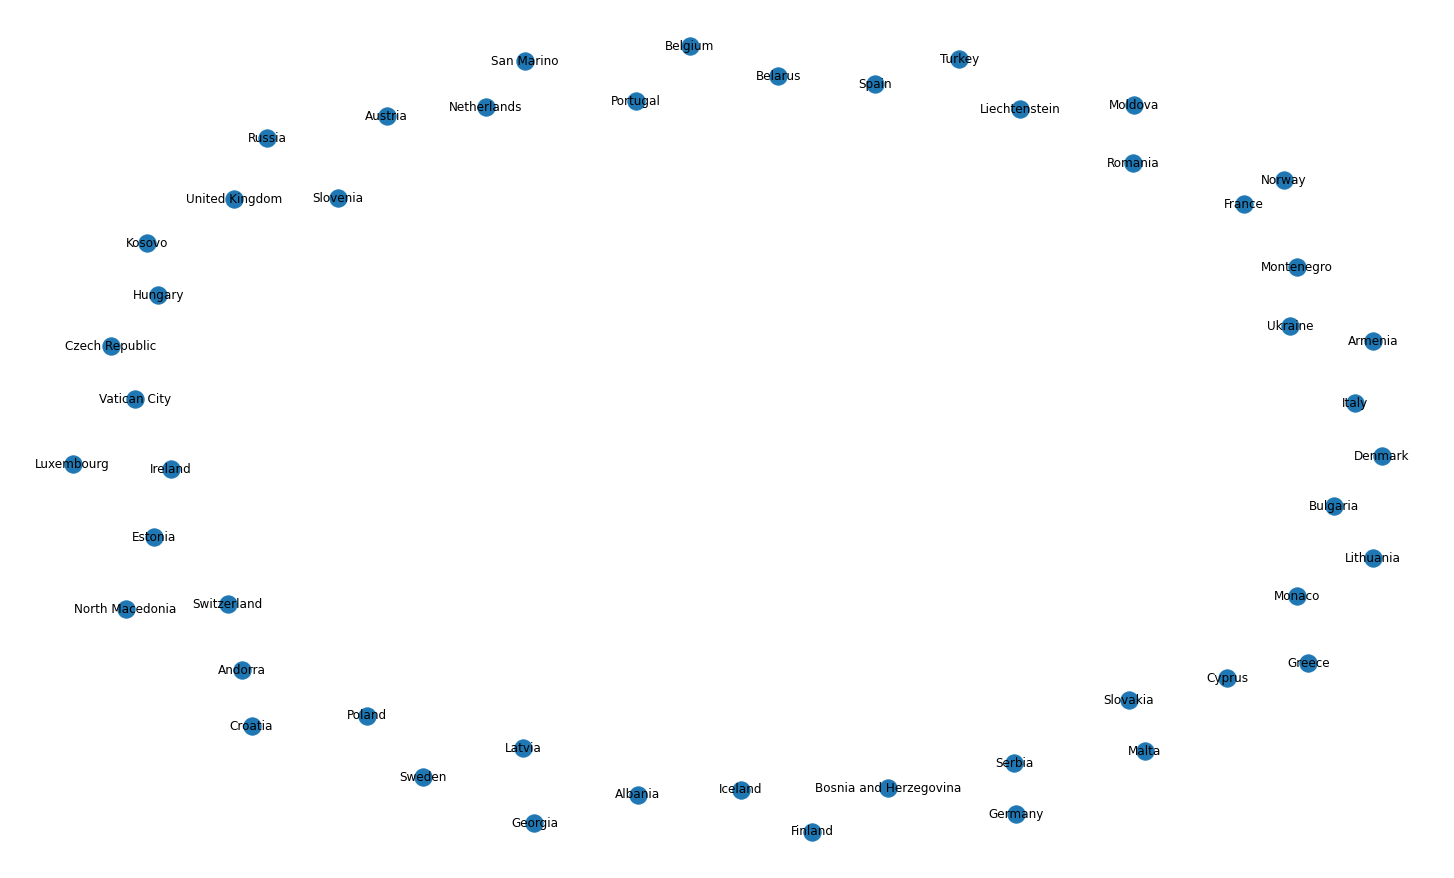

In [3]:
plt.figure(figsize=(20, 12))
nx.draw(Europe, with_labels=True)

In [4]:
sheet_id = '1XqOtPkiE_Q0dfGSoyxrH730RkwrTczcRbDeJJpqRByQ'
sheet_name = 'borders'
url = f'https://docs.google.com/spreadsheets/d/1AYODVslftthH3aI8gS0d4wgyLZwwXMpD4bQOSv5M4GI/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df = pd.read_csv(url)
df

,Country or territory\n*(Territories without full sovereignty in italics)* [2],Total length of land borders km[3],mi,No. of distinct land borders,No. of distinct land neighbours,Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory*
0,* Abkhazia*,382,237,2.0,2.0,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
1,* Afghanistan*,"5,529","3,436",6.0,6.0,People's Republic of China: 76 km (47 mi)\n Ir...
2,* Albania*,720,450,4.0,4.0,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
3,* Algeria*,"6,47","4,02",7.0,7.0,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
4,* Andorra*,120,75,2.0,2.0,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...,...,...,...,...
200,* Vietnam*,"4,639","2,883",3.0,3.0,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
201,* Western Sahara*[5],"2,046","1,271",3.0,3.0,"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
202,* Yemen*,"1,746","1,085",2.0,2.0,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
203,* Zambia*,"5,667","3,521",8.0,8.0,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


In [5]:
df.columns

Index(['Country or territory\n*(Territories without full sovereignty in italics)* [2] ',
       'Total length of land borders km[3]', 'mi',
       'No. of distinct land borders ', 'No. of distinct land neighbours ',
       'Land border neighbours\nand border length\n\n*(Territories without full sovereignty in italics) [2](#) = No. of distinct \nland boundaries with that country or territory* '],
      dtype='object')

In [6]:
borders = df.rename(columns={'Country or territory\n*(Territories'
                   ' without full sovereignty in italics)* [2] ': \
                   'country',
                   'Land border neighbours\nand border'
                   ' length\n\n*(Territories without full sovereignty in italics) '
                   '[2](#) = No. of distinct \nland boundaries with that country or territory* ': \
                   'neighbours'
                  }).drop(columns=['Total length of land borders km[3]', 'mi', 'No. of distinct land borders ', 'No. of distinct land neighbours '], axis=1)
borders

,country,neighbours
0,* Abkhazia*,Russia: 241 km (150 mi)\n Georgia: 141 km (88 mi)
1,* Afghanistan*,People's Republic of China: 76 km (47 mi)\n Ir...
2,* Albania*,Greece: 282 km (175 mi)\n* Kosovo*:[4] 112 km ...
3,* Algeria*,"Libya: 982 km (610 mi)\n Mali: 1,376 km (855 m..."
4,* Andorra*,France: 56.6 km (35.2 mi)\n Spain: 63.7 km (39...
...,...,...
200,* Vietnam*,"Cambodia: 1,228 km (763 mi)\n People's Republi..."
201,* Western Sahara*[5],"Algeria: 42 km (26 mi)\n Mauritania: 1,561 km ..."
202,* Yemen*,"Oman: 288 km (179 mi)\n Saudi Arabia: 1,458 km..."
203,* Zambia*,"Angola: 1,110 km (690 mi)\n Botswana: 0.15 km ..."


In [7]:
borders = df.rename(columns={'Country or territory\n*(Territories'
                   ' without full sovereignty in italics)* [2] ': \
                   'country',
                   'Land border neighbours\nand border'
                   ' length\n\n*(Territories without full sovereignty in italics) '
                   '[2](#) = No. of distinct \nland boundaries with that country or territory* ': \
                   'neighbours'
                  }).drop(columns=['Total length of land borders km[3]', 'mi', 'No. of distinct land borders ', 'No. of distinct land neighbours '], axis=1)
borders['country'] = borders['country'].str.replace('*', '').str.strip()
borders['country'] = borders['country'].str.replace(r'\[([0-9_]+)\]', '', regex=True) \
    .str.replace(r'\(([0-9_])+\)', '', regex=True)
# borders['neighbours'] = borders['neighbours'].str.split('\n')
borders.at[62, 'country'] = 'France'
borders.at[130, 'country'] = 'Netherlands'
# borders.sample(20)

/var/folders/6d/jcsgnwtj1857x2zvzznd28jw0000gn/T/ipykernel_3960/3368958005.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  borders['country'] = borders['country'].str.replace('*', '').str.strip()


In [8]:
edges_df = countries.merge(borders, how='left')
# edges_df['neighbours'] = edges_df['neighbours'].apply(str)
# edges_df['neighbours'] = [x.split(':')[0] for x in edges_df['neighbours']]
edges_df['neighbours'] =  edges_df['neighbours'].str.split('\n')
edges_df

,country,neighbours
0,Armenia,"[Azerbaijan (6): 787 km (489 mi)[8], Georgia:..."
1,Albania,"[Greece: 282 km (175 mi), * Kosovo*:[4] 112 km..."
2,Andorra,"[France: 56.6 km (35.2 mi), Spain: 63.7 km (3..."
3,Austria,"[Czech Republic: 362 km (225 mi), Germany: 78..."
4,Belarus,"[Latvia: 141 km (88 mi), Lithuania: 502 km (3..."
5,Belgium,"[France: 620 km (390 mi), Germany (6):[12] 16..."
6,Bosnia and Herzegovina,"[Croatia (2): 932 km (579 mi), Montenegro: 22..."
7,Bulgaria,"[Greece: 494 km (307 mi), North Macedonia: 14..."
8,Croatia,"[Bosnia and Herzegovina (2): 932 km (579 mi), ..."
9,Cyprus,[* Akrotiri and Dhekelia*[20] (United Kingdom)...


In [9]:
edges_df['neighbours'] = edges_df['neighbours'].fillna("").apply(list)

In [10]:
for index, row in edges_df.iterrows():
    for neighbour in row['neighbours']:
        temp = neighbour.split(':')[0].replace('*', '')
        temp = re.sub("\[([0-9_]+)\]", "", temp)
        temp = re.sub("\(([0-9_])+\)", "", temp)
        temp = temp.strip()
        if temp in list(edges_df['country']):
            # print(row['country'], temp)
            Europe.add_edge(row['country'], temp)


#### 1(a)

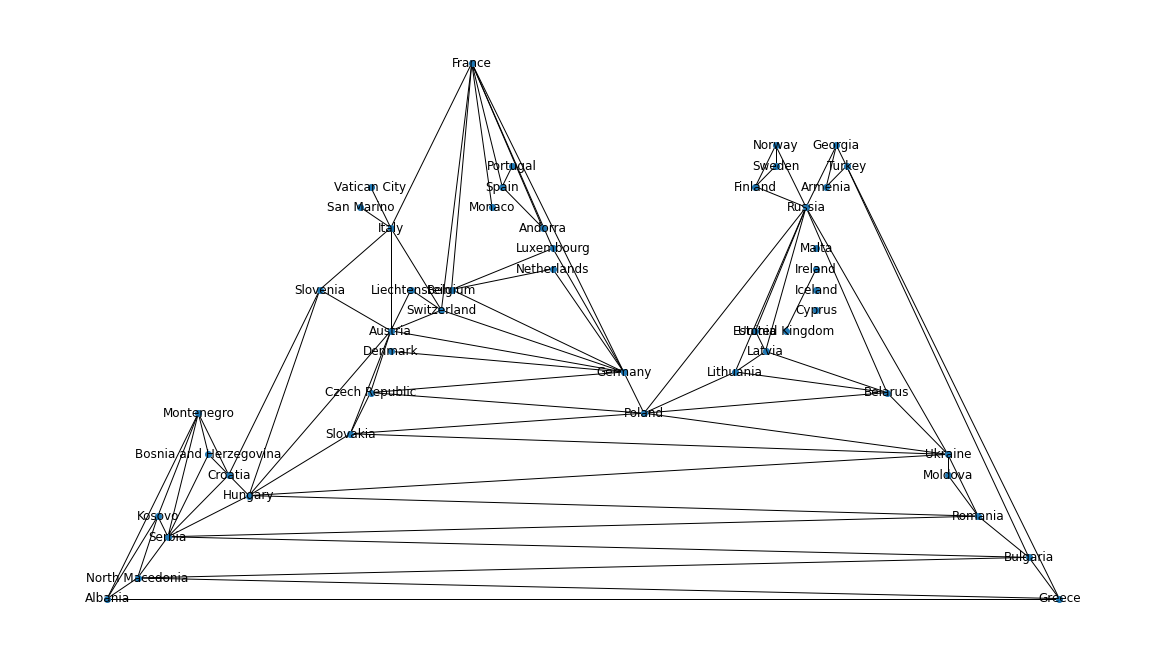

In [11]:
plt.figure(figsize=(16, 9))
nx.draw_planar(Europe, node_size=None, with_labels=True)

#### 1(b)

In [21]:
print('|V|:', Europe.number_of_nodes())
print('|E|:', Europe.number_of_edges())

min_graph_degree = 1
max_graph_degree = 0
# degree = 0 is too dull
for country, degree in Europe.degree():
    if degree != 0:
        min_graph_degree = min(min_graph_degree, degree)
        max_graph_degree = max(max_graph_degree, degree)
print('Minimal graph degree:', min_graph_degree)
print('Maximal graph degree:', max_graph_degree)

# nx.diameter(Europe) -> "Found infinite path length because the graph is not connected"
max_diameter = 0
for component in nx.connected_components(Europe):
    max_diameter = max(max_diameter, nx.diameter(Europe.subgraph(component)))
print('Diameter:', max_diameter)

print('Girth:', min([len(cycle) for cycle in nx.cycle_basis(Europe)]))

for component in nx.connected_components(Europe):
    print(f'\nCenter for a component{component}:', nx.center(Europe.subgraph(component)))
    print('Minimum vertex cut:' \
          , nx.minimum_node_cut(Europe.subgraph(component)))
    print('Minimum edge cut:' \
          , nx.minimum_edge_cut(Europe.subgraph(component)))  

|V|: 49
|E|: 92
Minimal graph degree: 1
Maximal graph degree: 9
Diameter: 8
Girth: 3

Center for a component{'Belarus', 'Belgium', 'Denmark', 'Monaco', 'Netherlands', 'Czech Republic', 'Armenia', 'Spain', 'Latvia', 'Georgia', 'Germany', 'Norway', 'Montenegro', 'Croatia', 'Austria', 'Kosovo', 'San Marino', 'Italy', 'Greece', 'Bosnia and Herzegovina', 'France', 'Albania', 'Slovenia', 'Russia', 'Turkey', 'Bulgaria', 'Liechtenstein', 'Moldova', 'Ukraine', 'Luxembourg', 'Switzerland', 'Romania', 'Sweden', 'Lithuania', 'Serbia', 'Portugal', 'Hungary', 'Finland', 'Slovakia', 'North Macedonia', 'Poland', 'Vatican City', 'Estonia', 'Andorra'}: ['Austria', 'Belarus', 'Croatia', 'Czech Republic', 'Germany', 'Hungary', 'Lithuania', 'Poland', 'Russia', 'Slovakia', 'Slovenia', 'Switzerland', 'Ukraine']
Minimum vertex cut: {'France'}
Minimum edge cut: {('San Marino', 'Italy')}

Center for a component{'Cyprus'}: ['Cyprus']
Minimum vertex cut: set()
Minimum edge cut: set()

Center for a component{'Icel

#### 1c

Colors:
0    16
1    15
2    11
3     6
4     1
dtype: int64


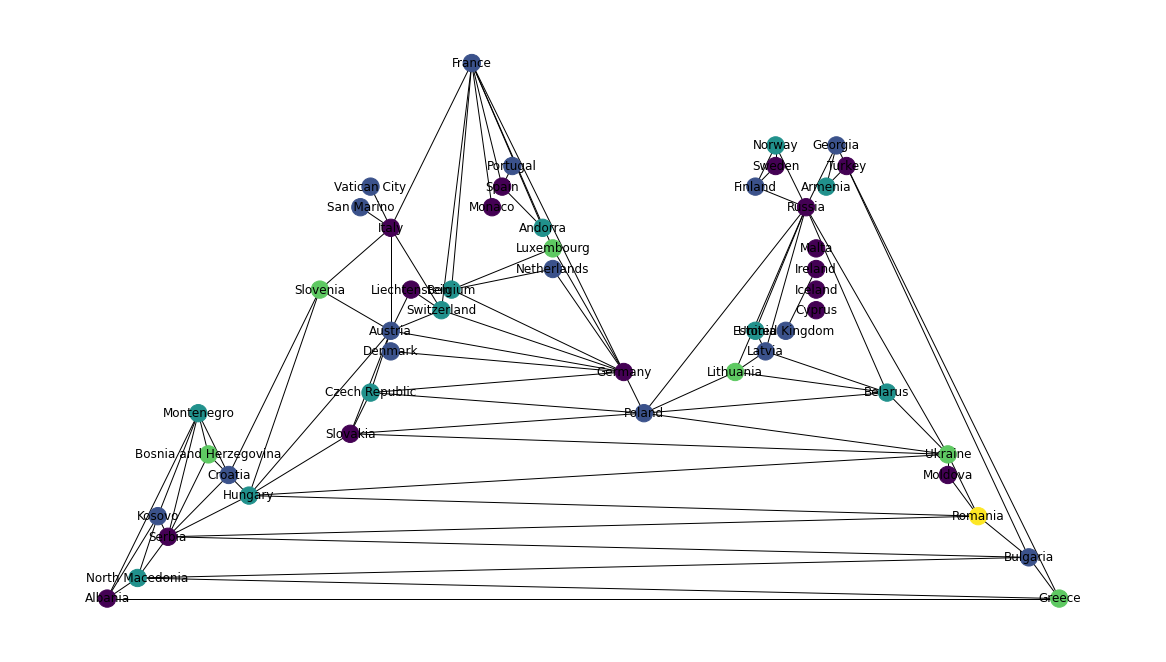

In [39]:
node_colors = nx.greedy_color(Europe)
color_map = []
for node in Europe:
    color_map.append(node_colors[node])
# color_map
print('Colors:')
print(pd.Series(node_colors.values()).value_counts())
plt.figure(figsize=(16, 9))
nx.draw_planar(Europe, node_color=color_map, with_labels=True)

#### 1d: TODO

In [40]:
Europe.edges()

EdgeView([('Armenia', 'Georgia'), ('Armenia', 'Turkey'), ('Albania', 'Greece'), ('Albania', 'Kosovo'), ('Albania', 'North Macedonia'), ('Albania', 'Montenegro'), ('Andorra', 'France'), ('Andorra', 'Spain'), ('Austria', 'Czech Republic'), ('Austria', 'Germany'), ('Austria', 'Hungary'), ('Austria', 'Italy'), ('Austria', 'Liechtenstein'), ('Austria', 'Slovakia'), ('Austria', 'Slovenia'), ('Austria', 'Switzerland'), ('Belarus', 'Latvia'), ('Belarus', 'Lithuania'), ('Belarus', 'Poland'), ('Belarus', 'Russia'), ('Belarus', 'Ukraine'), ('Belgium', 'France'), ('Belgium', 'Germany'), ('Belgium', 'Luxembourg'), ('Belgium', 'Netherlands'), ('Bosnia and Herzegovina', 'Croatia'), ('Bosnia and Herzegovina', 'Montenegro'), ('Bosnia and Herzegovina', 'Serbia'), ('Bulgaria', 'Greece'), ('Bulgaria', 'North Macedonia'), ('Bulgaria', 'Romania'), ('Bulgaria', 'Serbia'), ('Bulgaria', 'Turkey'), ('Croatia', 'Hungary'), ('Croatia', 'Montenegro'), ('Croatia', 'Serbia'), ('Croatia', 'Slovenia'), ('Czech Republi

#### 1e

In [57]:
cliques = list(nx.find_cliques_recursive(Europe))
max_clique_size = 0
for clique in cliques:
    max_clique_size = max(max_clique_size, len(clique))
max_clique_size
for clique in cliques:
    if len(clique) == max_clique_size:
        print('Maximum clique:', clique)
        break

Maximum clique ['Belarus', 'Russia', 'Ukraine', 'Poland']
